# VQA Pipeline

## Preparation

In [1]:
import sys, os
import reload_recursive

# sys path hack to allow importing the encoding functions and other modules
sys.path.insert(0, os.path.abspath("../src"))
sys.path.insert(0, os.path.abspath("../externals"))

In [2]:
import torch 

if torch.cuda.is_available():
    gpu = torch.device("cuda")
elif torch.backends.mps.is_available():
    gpu = torch.device("mps")
else:
    print("Warning: no GPU detected, falling back to CPU")
    gpu = torch.device("cpu")

In [3]:
# Clean old model from cache
if "model" in locals() or "model" in globals():
    del model
torch.cuda.empty_cache()

%reload model.clip_model
from model.clip_model import CLIPModel
model = CLIPModel(gpu)

# from model.xvlm_itr_coco_model import XVLMModel
# model = XVLMModel(gpu)

# from model.vipergpt_xvlm_model import XVLMModel
# model = XVLMModel(gpu)

In [4]:
# Clean old model from cache
if "object_detector" in locals() or "object_detector" in globals():
    del object_detector
torch.cuda.empty_cache()

%reload object_detection.owl_vit_object_detector
from object_detection.owl_vit_object_detector import OWLViTObjectDetector
object_detector = OWLViTObjectDetector(gpu)

### Reference Question

What is in the sky? -> clouds
select: sky (1706317)->relate: _,in,s (1706316) [0]->query: name [1]


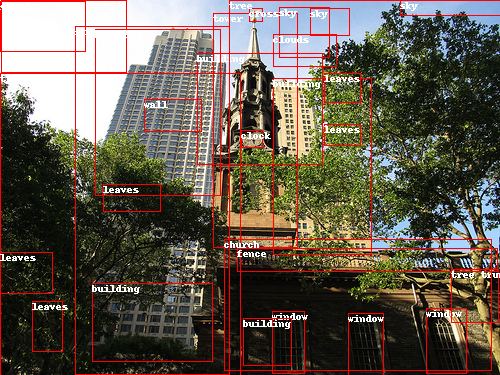

In [6]:
from PIL import Image, ImageDraw
import json

with open("../data/questions/val_sampled_questions_10000.json") as f:
   questions = list(json.load(f).items())

qid, question = next(q for q in questions if q[0] == "17236672")
print(f"{question['question']} -> {question['answer']}")
print(question["semanticStr"])
image = Image.open(f"../data/images/{question['imageId']}.jpg")

imgcopy = image.copy()
draw = ImageDraw.Draw(imgcopy)

for object in question["sceneGraph"]["objects"].values():
   object_crop = image.crop((object["x"], object["y"], object["x"]+object["w"], object["y"]+object["h"]))
   draw.rectangle((object["x"], object["y"], object["x"]+object["w"], object["y"]+object["h"]), outline="red", width=1)
   draw.text((object["x"], object["y"]), object["name"], fill="white")

imgcopy

## Object Detection

20


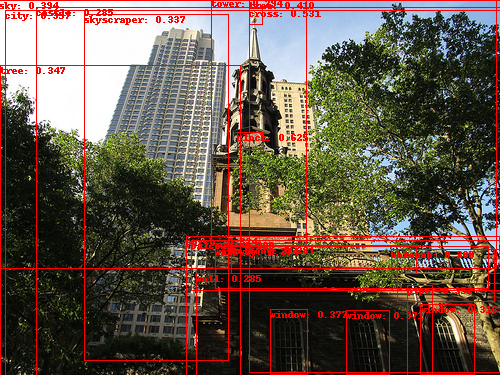

In [10]:
import json 
import torchvision.transforms.functional as F
import itertools

with open("../data/metadata/gqa_all_class.json") as f:
    all_classes = json.load(f)

all_child_classes = list(itertools.chain(*all_classes.values()))
detected_objects = object_detector.detect_objects(
    F.to_tensor(image), 
    [c.replace("_", " ") for c in all_child_classes]
)
print(len(detected_objects))
imgcopy = image.copy()
draw = ImageDraw.Draw(imgcopy)

for object in detected_objects:
   object_crop = image.crop((object["x"], object["y"], object["x"]+object["w"], object["y"]+object["h"]))
   draw.rectangle((object["x"], object["y"], object["x"]+object["w"], object["y"]+object["h"]), outline="red", width=1)
   draw.text((object["x"], object["y"]), f"{object['name']}: {object['score']:.3f}", fill="red")

imgcopy

## Concept Extraction

In [10]:
%reload pipeline.concept_extraction
from pipeline.concept_extraction import extract_attributes, extract_classes, extract_relations

print(question["semanticStr"])
print(extract_attributes(question))
print(extract_classes(question))
print(extract_relations(question))

select: toaster (1882309)->query: hposition [0]
(set(), set())
{'categories': set(), 'classes': {'toaster'}, 'all': False}
set()


## Bounding Box Optimization

In [13]:
image.size

(242, 500)

In [19]:
from torchvision.io import read_image, ImageReadMode

img = read_image(f"../data/images/{question['imageId']}.jpg", ImageReadMode.RGB)
img.shape

torch.Size([3, 500, 242])

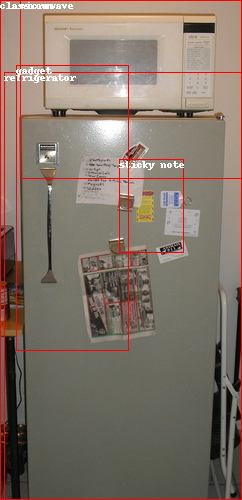

In [14]:
%reload pipeline.bounding_box_optimization
from pipeline.bounding_box_optimization import get_object_bboxes

object_bboxes = get_object_bboxes(detected_objects, {
    "h": image.size[1],
    "w": image.size[0]
})

imgcopy = image.copy()
draw = ImageDraw.Draw(imgcopy)

for i, object in enumerate(detected_objects[:5]):
    bbox = object_bboxes[i]

    draw.rectangle((bbox[1], bbox[0], bbox[3], bbox[2]), outline="red", width=1)
    draw.text((bbox[1], bbox[0]), f"{object['name']}", fill="white")

imgcopy

11


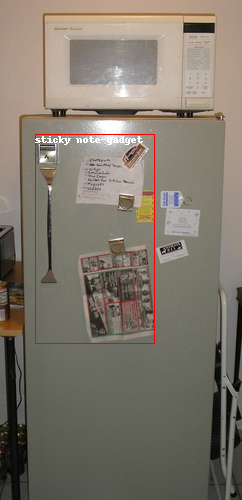

In [15]:
%reload pipeline.bounding_box_optimization
from pipeline.bounding_box_optimization import get_pair_bboxes

object_pairs = [(1,3)]
pair_bboxes, pair_bbox_indices = get_pair_bboxes(detected_objects, 0.6)

imgcopy = image.copy()
draw = ImageDraw.Draw(imgcopy)

print(len(pair_bboxes))

for object_pair in object_pairs:
    bbox = pair_bboxes[pair_bbox_indices[object_pair[0], object_pair[1]]]

    draw.rectangle((bbox[1], bbox[0], bbox[3], bbox[2]), outline="red", width=1)
    draw.text((bbox[1], bbox[0]), f"{detected_objects[object_pair[0]]['name']}-{detected_objects[object_pair[1]]['name']}", fill="white")

imgcopy

### Question-Driven Object Detection

	{'categories': set(), 'classes': {'toaster'}, 'all': False}
1


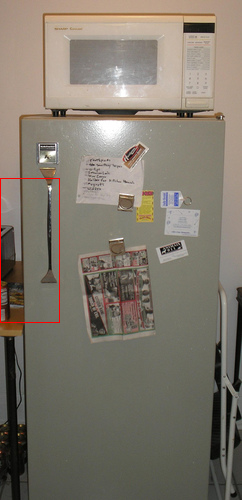

: 

In [20]:
%reload pipeline.encoding.scene_encoding
from pipeline.encoding.scene_encoding import detect_objects_question_driven

imgcopy = image.copy()
draw = ImageDraw.Draw(imgcopy)

detected_objects = detect_objects_question_driven(F.to_tensor(image), extract_classes(question), object_detector)
print(len(detected_objects))
imgcopy = image.copy()
draw = ImageDraw.Draw(imgcopy)

for object in detected_objects:
   object_crop = image.crop((object["x"], object["y"], object["x"]+object["w"], object["y"]+object["h"]))
   draw.rectangle((object["x"], object["y"], object["x"]+object["w"], object["y"]+object["h"]), outline="red", width=1)
   draw.text((object["x"], object["y"]), f"{object['name']}: {object['score']:.3f}", fill="white")

imgcopy

In [12]:
%reload pipeline.encoding
from pipeline.encoding import encode_scene

print(encode_scene(question, model, object_detector))

	{'categories': {'watercraft'}, 'classes': {'cabin'}, 'all': False}


object(o0).
has_object_weight(o0, 2610).
has_attribute(o0, class, cabin).
has_attribute(o0, class, building).
has_attribute(o0, name, cabin).
has_attribute(o0, hposition, middle).
has_attribute(o0, vposition, bottom).

{has_relation(o0, to_the_left_of, o1)}.
:~ has_relation(o0, to_the_left_of, o1). [296, (o0, to_the_left_of, o1)]
:~ not has_relation(o0, to_the_left_of, o1). [1359, (o0, to_the_left_of, o1)]

{has_relation(o0, to_the_left_of, o2)}.
:~ has_relation(o0, to_the_left_of, o2). [325, (o0, to_the_left_of, o2)]
:~ not has_relation(o0, to_the_left_of, o2). [1281, (o0, to_the_left_of, o2)]

{has_relation(o0, to_the_left_of, o3)}.
:~ has_relation(o0, to_the_left_of, o3). [390, (o0, to_the_left_of, o3)]
:~ not has_relation(o0, to_the_left_of, o3). [1129, (o0, to_the_left_of, o3)]

{has_relation(o0, to_the_left_of, o4)}.
:~ has_relation(o0, to_the_left_of, o4). [390, (o0, to_the_left_of, o4)]
:~ not has_relation(o0, to_the_left_of, o4). [1129, (o0, to_the_left_of, o4)]

{has_relation

## Testing

In [23]:
from clingo.control import Control 
from itertools import islice
%reload pipeline.encoding
from pipeline.encoding import encode_question, encode_scene, sanitize_asp

with open("../src/pipeline/encoding/theory.lp") as theory_file:
    theory = theory_file.read()

num_questions = 1000
correct = 0
incorrect = 0

def answer_is_correct(answers, correct_answer):
    correct = False 

    for answer in answers:
        if answer == sanitize_asp(correct_answer): 
            correct = True
        elif (answer == "to_the_right_of" and correct_answer == "right") or \
            (answer == "to_the_left_of" and correct_answer == "left") or \
            (answer == "in_front_of" and correct_answer == "front"):
            correct = True
    return correct 

def count_operators(operator_counts, question):
    for op in question["semantic"]:
        operator = op["operation"].split(" ")[0]
        if operator in operator_counts:
            operator_counts[operator] += 1
        else: 
            operator_counts[operator] = 1

wrong_operator_counts = {}
correct_operator_counts = {}

for qid, question in islice(questions, 0, num_questions):
    
    print(f"Attempting to solve question {qid}")
    print(f"\tQuestion: {question['question']}")
    print(f"\tSemantic: {question['semanticStr']}")
    print(f"\tImage: {question['imageId']}")
    if question["semantic"][0]["operation"] == "select" and question["semantic"][0]["argument"] == "scene":
        num_questions = num_questions - 1
        print("\tQuestion contains 'scene', skipping ...")
        continue

    ctl = Control()
    # ctl.configuration.solver.opt_strategy = "usc,3"
    ctl.add(theory)

    scene_encoding = encode_scene(question, model, object_detector)
    question_encoding = encode_question(question)

    with open(f"../data/encoded_questions/{qid}.lp", "w") as f:
        f.write("% ------ scene encoding ------\n")
        f.write(scene_encoding)
        f.write("\n% ------ question encoding ------\n")
        f.write(question_encoding)

    ctl.add(scene_encoding)
    ctl.add(question_encoding)

    answers = [[]]
    def on_model(model):
        answers[0] = [s.arguments[0].name for s in model.symbols(shown=True)]

    ctl.ground()
    handle = ctl.solve(on_model=on_model, async_ = True)
    has_finished = handle.wait(timeout=10.0)
    
    if not has_finished:
        print("\tSearch was timed out after 10 seconds!")
    
    if len(answers[0]) > 0:
        if(answer_is_correct(answers[0], question["answer"])):
            print(f"\tResult: correct answer - {answers[0][0]}")
            count_operators(correct_operator_counts, question)
            correct = correct + 1
        else: 
            print(f"\tResult: incorrect answer - {answers[0][0]} (correct: {question['answer']})")
            count_operators(wrong_operator_counts, question)
            incorrect = incorrect + 1
    else: 
        print(f"\tResult: UNSAT")
        count_operators(wrong_operator_counts, question)
        incorrect = incorrect + 1

print("===============================")
print(f"Total questions: {num_questions}")
print(f"Correct: {correct}")
print(f"Incorrect: {incorrect}")
print(f"Percentage: {correct/num_questions*100:.3f}%")

print("-------------------------------")
print("Operator failure rate:")
print(wrong_operator_counts)
print(correct_operator_counts)
operator_failure_rates = {}
for operator in {*wrong_operator_counts.keys(), *correct_operator_counts.keys()}:
    if operator in correct_operator_counts and operator in wrong_operator_counts:
        operator_failure_rates[operator] = wrong_operator_counts[operator]/(wrong_operator_counts[operator]+correct_operator_counts[operator])
    elif operator in wrong_operator_counts: 
        operator_failure_rates[operator] = 1
    else:
        operator_failure_rates[operator] = 0

for operator, failure_rate in sorted(operator_failure_rates.items(), key=lambda item: item[1], reverse=True):
    print(f"{operator}: {failure_rate*100:.3f}%")

Attempting to solve question 07787914
	Question: Do you see a door that is not red?
	Semantic: select: door (2102911)->filter color: not(red) [0]->exist: ? [1]
	Image: 2369089
	{'categories': set(), 'classes': {'door'}, 'all': False}
	Result: correct answer - no
Attempting to solve question 19560907
	Question: Who is wearing a shirt?
	Semantic: select: shirt (1282189)->relate: person,wearing,s (1282164) [0]->query: name [1]
	Image: 2386810
	{'categories': {'person'}, 'classes': {'shirt'}, 'all': False}
	Result: correct answer - man
Attempting to solve question 07328145
	Question: What is the watercraft to the left of the cabin?
	Semantic: select: cabin (800346)->relate: watercraft,to the left of,s (800339) [0]->query: name [1]
	Image: 2358661
	{'categories': {'watercraft'}, 'classes': {'cabin'}, 'all': False}
	Result: correct answer - boat
Attempting to solve question 17680743
	Question: What is the pan on?
	Semantic: select: pan (633147)->relate: _,on,o (633148) [0]->query: name [1]
	